In [174]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [175]:
paths = ['1_day_-2', '1_day_-1', '1_day_0',
         '3_day_0',  '3_day_1',  '3_day_2',
         '4_day_1',  '4_day_2',  '4_day_3']

def get_data(path, price_data = False):
    if price_data:
        return pd.read_csv(f'../prices/prices_round_{path}.csv', sep=';', header=0)
    return pd.read_csv(f'../prices/trades_round_5/trades_round_{path}_wn.csv', sep=';', header=0)

get_data(paths[6]).head()

,timestamp,buyer,seller,symbol,currency,price,quantity
0,800,Valentina,Valentina,COCONUT_COUPON,SEASHELLS,636.0,5
1,900,Valentina,Vinnie,COCONUT_COUPON,SEASHELLS,634.0,17
2,1100,Valentina,Ruby,COCONUT_COUPON,SEASHELLS,635.0,17
3,1900,Valentina,Vinnie,COCONUT_COUPON,SEASHELLS,635.0,16
4,2000,Valentina,Vinnie,COCONUT_COUPON,SEASHELLS,637.0,14


In [176]:
def calculate_specific_profits(trades, prices, trader, product):
    last_price = prices[(prices['timestamp'] == prices['timestamp'].max()) & (prices['product'] == product)]['mid_price'].values[0]

    df = trades[(trades['buyer'] == trader) & (trades['symbol'] == product)]
    profit = (df['price'] * df['quantity']).sum()
    position = df['quantity'].sum()
    
    df = trades[(trades['seller'] == trader) & (trades['symbol'] == product)]
    profit -= (df['price'] * df['quantity']).sum()
    position -= df['quantity'].sum()

    return profit - position * last_price

In [177]:
vipers = ['Valentina', 'Vinnie', 'Vladimir', 'Vivian']
cobras = ['Celeste', 'Colin', 'Carlos', 'Camilla']
pythons = ['Pablo', 'Penelope', 'Percy', 'Petunia']
rattlesnakes = ['Ruby', 'Remy', 'Rihanna', 'Raj']
anacondas = ['Amelia', 'Adam', 'Alina', 'Amir']
traders = vipers + cobras + pythons + rattlesnakes + anacondas

products = ['AMETHYSTS', 'STARFRUIT', 'ORCHIDS', 'CHOCOLATE', 'ROSES', 'STRAWBERRIES', 'GIFT_BASKET', 'COCONUT', 'COCONUT_COUPON']

In [178]:
profits = {product: {trader: 0 for trader in traders} for product in products}
for path in paths:
    trades = get_data(path)
    prices = get_data(path, price_data=True)

    unique_traders = pd.concat([trades['buyer'], trades['seller']], axis=0).unique()
    unique_products = trades['symbol'].unique()
    for trader in traders:
        if trader not in unique_traders:
            continue
        for product in products:
            if product not in unique_products:
                continue
            profits[product][trader] += calculate_specific_profits(trades, prices, trader, product)

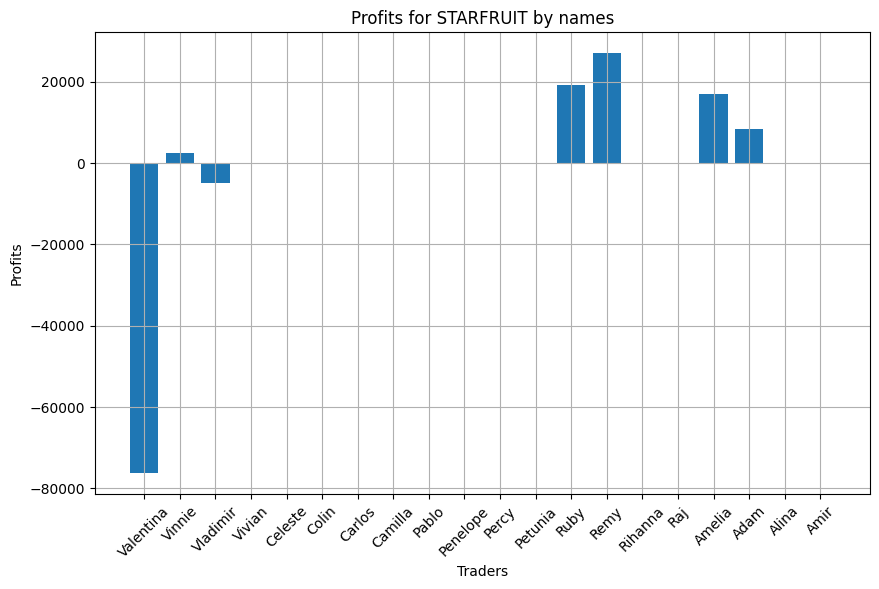

In [238]:
visualizing_product = 'STARFRUIT'

plt.figure(figsize=(10, 6))
plt.bar(traders, list(profits[visualizing_product].values()))
plt.xticks(rotation=45)
plt.grid()
plt.ylabel('Profits')
plt.xlabel('Traders')
plt.title(f'Profits for {visualizing_product} by names')
plt.show()


In [245]:
visualizing_path_index = 2
visualizing_trader = 'Valentina'

trades = get_data(paths[visualizing_path_index])
trades = trades[trades['symbol'] == visualizing_product]
print(pd.concat([trades['buyer'], trades['seller']], axis=0).unique())

['Rhianna' 'Valentina' 'Remy' 'Adam' 'Vinnie' 'Vladimir' 'Ruby' 'Amelia']


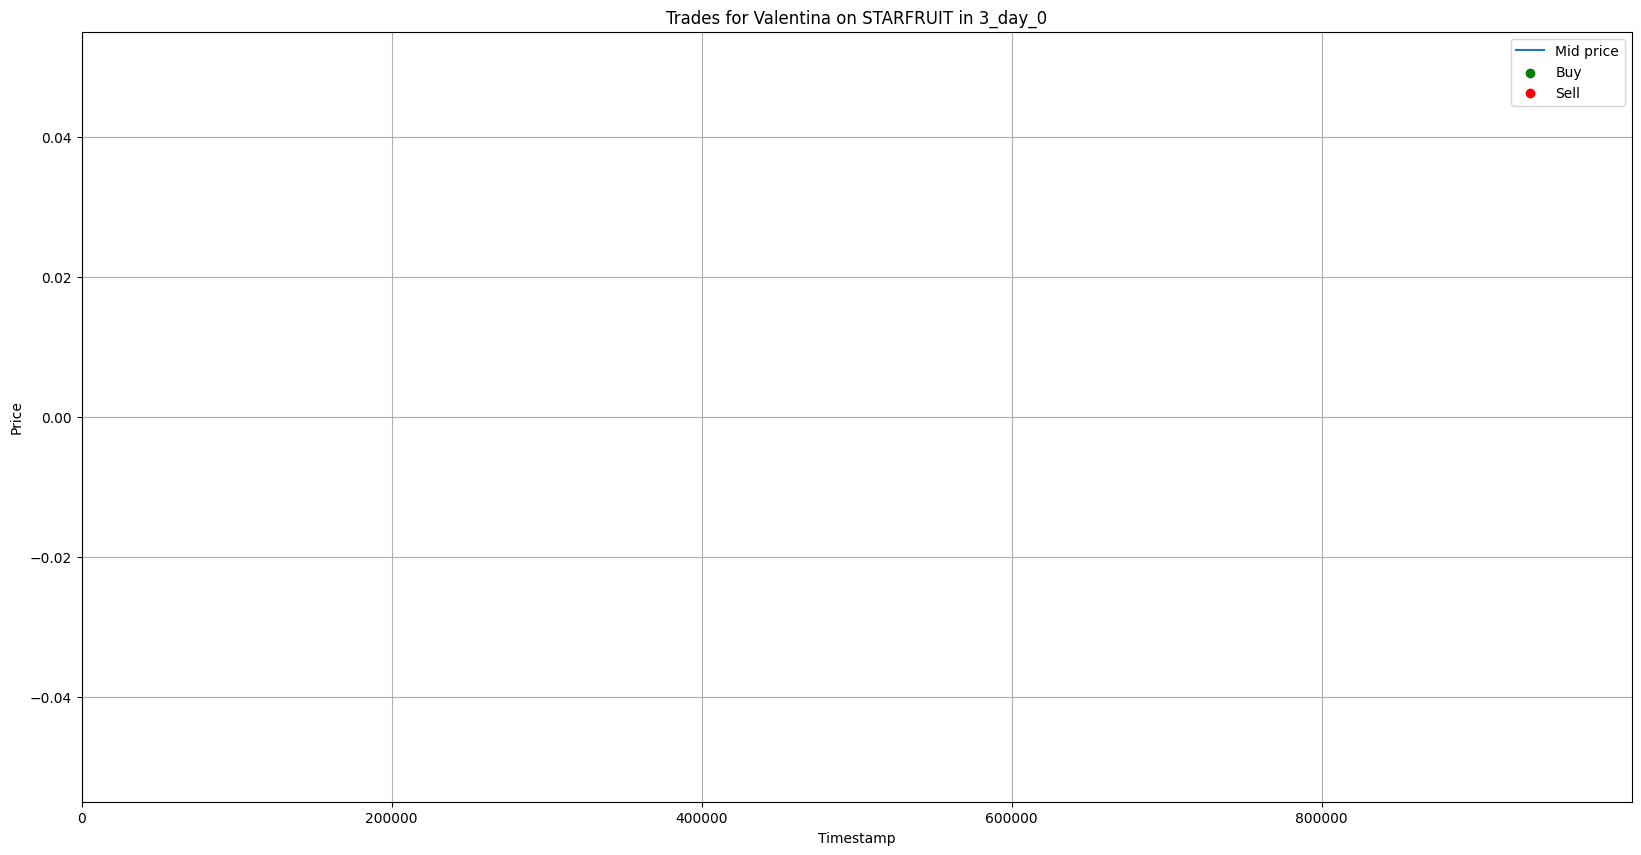

In [181]:
def plot_trades(path, trader, product):
    trades = get_data(path)
    prices = get_data(path, price_data=True)

    df = trades[(trades['buyer'] == trader) & (trades['symbol'] == product)]
    plt.figure(figsize=(20, 10))
    plt.plot(prices[prices['product'] == product]['timestamp'], prices[prices['product'] == product]['mid_price'], label='Mid price')
    plt.scatter(df['timestamp'], df['price'], label='Buy', color='green')
    df = trades[(trades['seller'] == trader) & (trades['symbol'] == product)]
    plt.scatter(df['timestamp'], df['price'], label='Sell', color='red')
    plt.legend()
    plt.grid()
    plt.ylabel('Price')
    plt.xlabel('Timestamp')
    plt.xlim(prices['timestamp'].min(), prices['timestamp'].max())
    plt.title(f'Trades for {trader} on {product} in {path}')
    plt.show()

plot_trades(paths[visualizing_path_index], visualizing_trader, visualizing_product)

Average change: 0.21992580816110227. Max position: 416. Min position: -134.


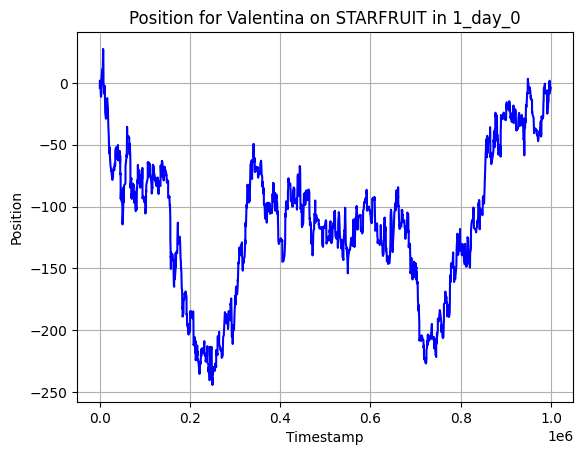

In [246]:
def calculate_position_per_timestamp(trades, trader, product):
    df = trades[((trades['buyer'] == trader) | (trades['seller'] == trader)) & (trades['symbol'] == product)]
    df.loc[df['seller'] == trader, 'quantity'] *= -1
    position = df['quantity'].cumsum()

    return position, df['timestamp']

visualizing_position, timestamps = calculate_position_per_timestamp(trades, visualizing_trader, visualizing_product)
print(f"Average change: {visualizing_position.diff().mean()}. Max position: {visualizing_position.max()}. Min position: {visualizing_position.min()}.")

visualizing_position -= np.arange(0,len(visualizing_position),1) * visualizing_position.diff().mean()
plt.plot(timestamps, visualizing_position, label='Position', color='blue')
plt.grid()
plt.ylabel('Position')
plt.xlabel('Timestamp')
plt.title(f'Position for {visualizing_trader} on {visualizing_product} in {paths[visualizing_path_index]}')
plt.show()

In [255]:
path_indices = [0,1,2]
regression_product = 'STARFRUIT'
regression_traders = ['Rhianna', 'Valentina', 'Remy', 'Adam', 'Vinnie', 'Vladimir', 'Ruby', 'Amelia']

regression_df = None
for path_index in path_indices:
    trades = get_data(paths[path_index])
    prices = get_data(paths[path_index], price_data=True)
    table = pd.DataFrame({'timestamp': prices['timestamp'].unique(), 'mid_price': prices[prices['product'] == regression_product]['mid_price'].pct_change()})
    for trader in regression_traders:
        position, timestamps = calculate_position_per_timestamp(trades, trader, regression_product)
        table = pd.merge(table, pd.DataFrame({f'{trader}_position': position, 'timestamp': timestamps}), on='timestamp', how='left')
    if regression_df is None:
        regression_df = table
    else:
        regression_df = pd.concat([regression_df, table])

columns_to_shift = [col for col in regression_df.columns if col not in ['timestamp', 'mid_price']]
regression_df[columns_to_shift] = regression_df[columns_to_shift].shift(1)
regression_df['mid_price'] = regression_df['mid_price'].shift(-1)
regression_df.loc[0, columns_to_shift] = 0
regression_df[columns_to_shift] = regression_df[columns_to_shift].ffill()

regression_df = regression_df.dropna()
regression_df.tail(10)


,timestamp,mid_price,Rhianna_position,Valentina_position,Remy_position,Adam_position,Vinnie_position,Vladimir_position,Ruby_position,Amelia_position
10526,998900,0.000000,41.0,409.0,-84.0,93.0,-283.0,-25.0,-139.0,-45.0
10527,999000,-0.000198,41.0,409.0,-84.0,93.0,-283.0,-25.0,-139.0,-45.0
10528,999100,-0.000099,41.0,409.0,-84.0,93.0,-283.0,-25.0,-139.0,-45.0
10529,999200,0.000099,41.0,409.0,-84.0,93.0,-283.0,-25.0,-139.0,-45.0
10530,999300,-0.000099,41.0,409.0,-84.0,93.0,-283.0,-25.0,-139.0,-45.0
10531,999400,0.000198,41.0,409.0,-84.0,93.0,-283.0,-25.0,-139.0,-45.0
10532,999500,-0.000297,41.0,409.0,-84.0,93.0,-283.0,-25.0,-139.0,-45.0
10533,999600,0.000495,41.0,411.0,-86.0,93.0,-283.0,-25.0,-139.0,-45.0
10534,999700,-0.000792,41.0,411.0,-87.0,93.0,-283.0,-24.0,-139.0,-45.0
10535,999800,0.000297,41.0,411.0,-87.0,93.0,-283.0,-24.0,-139.0,-45.0


In [256]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

X = regression_df[columns_to_shift + ['timestamp']]
y = regression_df['mid_price']

model = LinearRegression()
model.fit(X, y)
predictions = model.predict(X)
print(f'mean error: {np.mean(abs(y - predictions))}')
print(f'mean movement: {np.mean(abs(y))}')
print(model.coef_)

mean error: 0.0002497718965140475
mean movement: 0.00024910936348317484
[1.64550742e-06 1.64955231e-06 1.68310677e-06 1.65642762e-06
 1.73091511e-06 1.57341735e-06 1.62999116e-06 1.61119368e-06
 7.74536280e-11]
